In [1]:
!pip -q install ftfy regex tqdm
!pip -q install git+https://github.com/openai/CLIP.git
!pip -q install umap-learn scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
from torchvision.datasets import STL10
from tqdm import tqdm
import clip
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.manifold import TSNE
import umap
from scipy.linalg import orthogonal_procrustes

In [3]:
MODEL_NAME = "ViT-B/32"
BATCH_SIZE = 128
NUM_WORKERS = 4
DATA_ROOT = "./data"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSNAMES = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]
DESCRIPTIVE_PROMPTS = {
        "airplane": "a photo of an airplane flying in the sky",
        "bird": "a photo of a bird with wings and feathers",
        "car": "a photo of a car on a road",
        "cat": "a photo of a small domestic cat with fur and whiskers",
        "deer": "a photo of a deer with antlers in nature",
        "dog": "a photo of a dog with a snout and fur",
        "horse": "a photo of a horse standing on grass",
        "monkey": "a photo of a monkey with a tail in a forest",
        "ship": "a photo of a ship or boat on the water",
        "truck": "a photo of a large truck vehicle on a road",
}
model, preprocess = clip.load(MODEL_NAME, device=DEVICE)
testDataSet = STL10(root="./data", split="test", download=True, transform=preprocess)
testLoader = DataLoader(
        testDataSet,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(DEVICE == "cuda"),
)
model.eval()

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 56.5MiB/s]
100%|██████████| 2.64G/2.64G [00:39<00:00, 67.4MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [8]:
def promptsPlain(classnames):
    return classnames

def promptsTemplate(classnames):
    return [f"a photo of a {className}" for className in classnames]

def promptsDescriptive(classnames):
    return [DESCRIPTIVE_PROMPTS[className] for className in classnames]

@torch.no_grad()
def builtTextFeatures(model, prompt_texts, device):
    tokens = clip.tokenize(prompt_texts).to(device)
    textFeatures = model.encode_text(tokens)
    textFeatures = textFeatures / textFeatures.norm(dim=-1, keepdim=True)
    return textFeatures

@torch.no_grad()
def evaluateZeroShot(model, dataloader, textFeatures, device):
    correct = 0
    total = 0
    for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        imageFeatures = model.encode_image(images)
        imageFeatures = imageFeatures / imageFeatures.norm(dim=-1, keepdim=True)
        logits = 100.0 * imageFeatures @ textFeatures.t()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.numel()
    return correct / total


In [13]:
def main():
    print(f"Device: {DEVICE}")
    strategies = {
        "plain": promptsPlain(CLASSNAMES),
        "template": promptsTemplate(CLASSNAMES),
        "descriptive": promptsDescriptive(CLASSNAMES),
    }
    results = {}
    for name, promptTexts in strategies.items():
        print(f"\n {name}")
        print("Prompts:", promptTexts[:3])
        textFeatures = builtTextFeatures(model, promptTexts, DEVICE)
        acc = evaluateZeroShot(model, testLoader, textFeatures, DEVICE)
        results[name] = acc
        print(f"Accuracy of ({name}): {acc*100:.2f}%")

    print("\n Overall Summary")
    for name, acc in results.items():
        print(f"{name:12s}: {acc*100:.2f}%")

main()

Device: cuda

 plain
Prompts: ['airplane', 'bird', 'car']


Accuracy of (plain): 96.26%

 template
Prompts: ['a photo of a airplane', 'a photo of a bird', 'a photo of a car']


Accuracy of (template): 97.36%

 descriptive
Prompts: ['a photo of an airplane flying in the sky', 'a photo of a bird with wings and feathers', 'a photo of a car on a road']


Accuracy of (descriptive): 94.00%

 Overall Summary
plain       : 96.26%
template    : 97.36%
descriptive : 94.00%


## Part 2

In [9]:
# got (50-100) STL-10 samples
indices = list(range(100))
subset = Subset(testDataSet, indices)
loader = DataLoader(subset, batch_size=32, shuffle=False)

imageEmbeddings = []
textEmbeddings = []

with torch.no_grad():
    textTokens = clip.tokenize([f"a photo of a {c}" for c in CLASSNAMES]).to(DEVICE)
    textFeatures = model.encode_text(textTokens)
    textFeatures = textFeatures / textFeatures.norm(dim=-1, keepdim=True)
    textEmbeddings = textFeatures.cpu().numpy()
    for images, labels in loader:
        images = images.to(DEVICE)
        feats = model.encode_image(images)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        imageEmbeddings.append(feats.cpu().numpy())

imageEmbeddings = np.concatenate(imageEmbeddings, axis=0)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


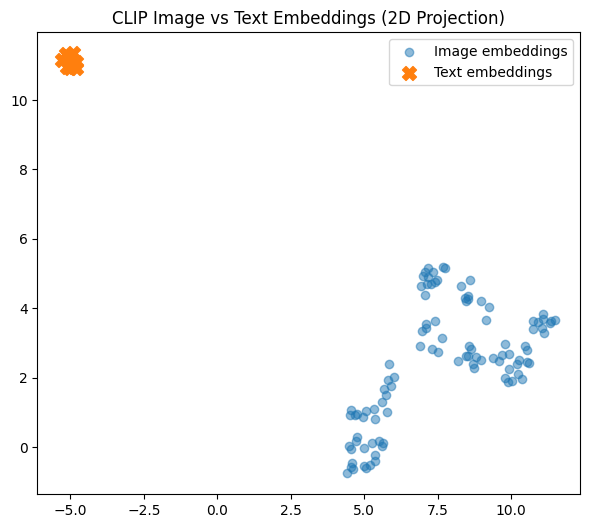

In [10]:
#dimenstionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embeddings2d = reducer.fit_transform(
    np.vstack([imageEmbeddings, textEmbeddings])
)
#visualize
img2d = embeddings2d[:len(imageEmbeddings)]
text2d = embeddings2d[len(imageEmbeddings):]
plt.figure(figsize=(7, 6))
plt.scatter(img2d[:, 0], img2d[:, 1], alpha=0.5, label="Image embeddings")
plt.scatter(text2d[:, 0], text2d[:, 1], marker="X", s=100, label="Text embeddings")
plt.legend()
plt.title("CLIP Image vs Text Embeddings (2D Projection)")
plt.show()

## Part 3
Solve min || X R - Y ||_F  s.t. R^T R = I  (orthogonal rotation).


Learned R shape: (512, 512)



Baseline accuracy (no alignment): 97.36%
Aligned accuracy (Procrustes):     97.79%


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


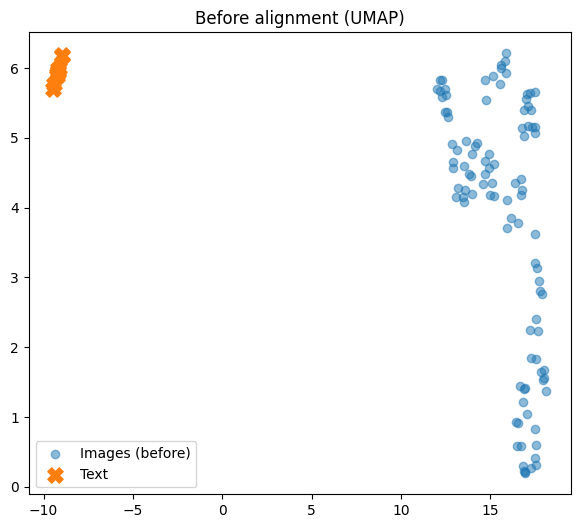

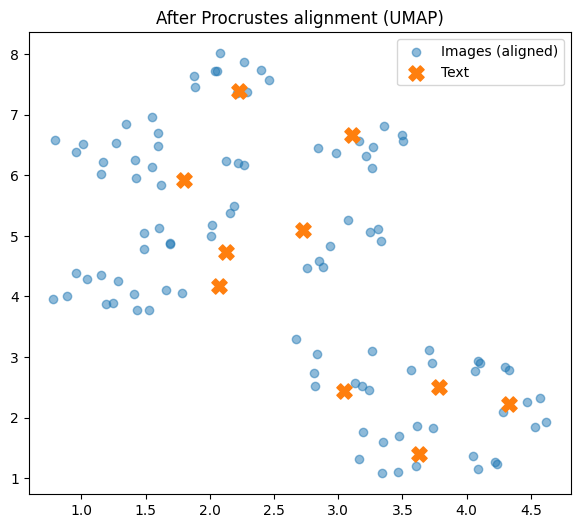

In [7]:
NUM_WORKERS = 2
def buildPrompts(classnames):# choosing template prompt for which accuracy was highest in first part of this task
    def a_or_an(word):
        return "an" if word[0].lower() in "aeiou" else "a"
    return [f"a photo of {a_or_an(c)} {c}" for c in classnames]
PROMPTS = buildPrompts(CLASSNAMES)

@torch.no_grad()
def getTextFeatures(model):
    tokens = clip.tokenize(PROMPTS).to(DEVICE)
    t = model.encode_text(tokens)
    t = t / t.norm(dim=-1, keepdim=True)
    return t.cpu().numpy()

@torch.no_grad()
def extractImageFeatures(model, dataloader):
    featsList, labelsList = [], []
    for images, labels in tqdm(dataloader, desc="Extracting", leave=False):
        images = images.to(DEVICE)
        feats = model.encode_image(images)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        featsList.append(feats.cpu().numpy())
        labelsList.append(labels.numpy())
    return np.concatenate(featsList, axis=0), np.concatenate(labelsList, axis=0)

def accuracyFromFeatures(XImg, TText):
    logits = XImg @ TText.T  # cosine similarity as both are normalized
    return logits.argmax(axis=1)

def computeAcc(preds, labels):
    return (preds == labels).mean()

def fitProcrustesRotation(X, Y):
    R, _ = orthogonal_procrustes(X, Y)
    return R  #DxD

def project2d(data, method="umap"):
   reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
   return reducer.fit_transform(data)


def main():
    T = getTextFeatures(model)
    # training for learning R
    trainDataset= STL10(root=DATA_ROOT, split="train", download=True, transform=preprocess)
    train_idx = list(range(min(2000, len(trainDataset))))
    trainLoader = DataLoader(
        Subset(trainDataset, list(range(min(2000, len(trainDataset))))),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(DEVICE == "cuda"),
    )

    X_train, y_train = extractImageFeatures(model, trainLoader)  # (N, D), (N,)
    # pairing each image feature with its corresponding class text feature
    Y_train = T[y_train]  # NxD

    # applying procrustes rotation R
    R = fitProcrustesRotation(X_train, Y_train)
    print("Learned R shape:", R.shape)

    # apply R to training image features
    X_train_aligned = X_train @ R
    # renormalize (orthogonal keeps norm, but numeric drift can happen)
    X_train_aligned = X_train_aligned / np.linalg.norm(X_train_aligned, axis=1, keepdims=True)

    #evaluation on test split for baseline vs aligned
    testLoader = DataLoader(
        STL10(root=DATA_ROOT, split="test", download=True, transform=preprocess),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(DEVICE == "cuda"),
    )

    X_test, y_test = extractImageFeatures(model, testLoader)

    # without alignment
    preds_base = accuracyFromFeatures(X_test, T)
    acc_base = computeAcc(preds_base, y_test)

    # rotate image embeddings for alignment
    X_test_aligned = X_test @ R
    X_test_aligned = X_test_aligned / np.linalg.norm(X_test_aligned, axis=1, keepdims=True)
    preds_aligned = accuracyFromFeatures(X_test_aligned, T)
    acc_aligned = computeAcc(preds_aligned, y_test)

    print(f"\nBaseline accuracy (no alignment): {acc_base*100:.2f}%")
    print(f"Aligned accuracy (Procrustes):     {acc_aligned*100:.2f}%")

    # Before vs After on a small subset
    viz_n = 100
    X_viz = X_test[:viz_n]
    y_viz = y_test[:viz_n]
    X_viz_aligned = X_test_aligned[:viz_n]

    # visualization for comparison
    before = np.vstack([X_viz, T])
    after  = np.vstack([X_viz_aligned, T])

    method = "umap"
    before_2d = project2d(before, method=method)
    after_2d  = project2d(after, method=method)

    img_before_2d = before_2d[:viz_n]
    txt_before_2d = before_2d[viz_n:]

    img_after_2d = after_2d[:viz_n]
    txt_after_2d = after_2d[viz_n:]

    plt.figure(figsize=(7, 6))
    plt.scatter(img_before_2d[:,0], img_before_2d[:,1], alpha=0.5, label="Images (before)")
    plt.scatter(txt_before_2d[:,0], txt_before_2d[:,1], marker="X", s=120, label="Text")
    plt.title(f"Before alignment ({method.upper()})")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 6))
    plt.scatter(img_after_2d[:,0], img_after_2d[:,1], alpha=0.5, label="Images (aligned)")
    plt.scatter(txt_after_2d[:,0], txt_after_2d[:,1], marker="X", s=120, label="Text")
    plt.title(f"After Procrustes alignment ({method.upper()})")
    plt.legend()
    plt.show()


main()
